Skipping incomplete record: {'id': 16395, 'img': 'img/16395.png', 'text': 'handjobs sold seperately'}
Skipping incomplete record: {'id': 37405, 'img': 'img/37405.png', 'text': 'introducing fidget spinner for women'}
Skipping incomplete record: {'id': 94180, 'img': 'img/94180.png', 'text': "happy pride month let's go beat up lesbians"}
Skipping incomplete record: {'id': 54321, 'img': 'img/54321.png', 'text': 'laughs in [majority of u.s crime rate]'}
Skipping incomplete record: {'id': 97015, 'img': 'img/97015.png', 'text': 'finds out those 72 virgins.. are goats'}
Skipping incomplete record: {'id': 73506, 'img': 'img/73506.png', 'text': 'look your dad fucked goats.. i capped him...sorry..'}
Skipping incomplete record: {'id': 5429, 'img': 'img/05429.png', 'text': 'claims that her ancestors created a safe space for jews these are her ancestors'}
Skipping incomplete record: {'id': 70691, 'img': 'img/70691.png', 'text': 'overdose'}
Skipping incomplete record: {'id': 69421, 'img': 'img/69421.

Evaluating: 100%|██████████| 113/113 [00:15<00:00,  7.32it/s]


Train Loss: 0.7577 | Val Loss: 0.6860 | Val Acc: 0.6156 | Val F1: 0.5850
✓ Saved best model! (F1: 0.5850)

Epoch 2/25


Evaluating: 100%|██████████| 113/113 [00:15<00:00,  7.34it/s]


Train Loss: 0.7153 | Val Loss: 0.6993 | Val Acc: 0.3611 | Val F1: 0.1916

Epoch 3/25


Evaluating: 100%|██████████| 113/113 [00:17<00:00,  6.45it/s]


Train Loss: 0.7019 | Val Loss: 0.7022 | Val Acc: 0.3611 | Val F1: 0.1916

Epoch 4/25


Evaluating: 100%|██████████| 113/113 [00:17<00:00,  6.58it/s]


Train Loss: 0.7001 | Val Loss: 0.6931 | Val Acc: 0.4822 | Val F1: 0.4870

Epoch 5/25


Evaluating: 100%|██████████| 113/113 [00:17<00:00,  6.57it/s]


Train Loss: 0.7137 | Val Loss: 0.6928 | Val Acc: 0.6389 | Val F1: 0.4981

Epoch 6/25


Evaluating: 100%|██████████| 113/113 [00:17<00:00,  6.53it/s]


Train Loss: 0.7001 | Val Loss: 0.6977 | Val Acc: 0.3611 | Val F1: 0.1916

Epoch 7/25


Evaluating: 100%|██████████| 113/113 [00:17<00:00,  6.53it/s]


Train Loss: 0.6975 | Val Loss: 0.6930 | Val Acc: 0.6389 | Val F1: 0.4981

Epoch 8/25


Evaluating: 100%|██████████| 113/113 [00:17<00:00,  6.48it/s]


Train Loss: 0.6969 | Val Loss: 0.6940 | Val Acc: 0.6389 | Val F1: 0.4981

Epoch 9/25


Evaluating: 100%|██████████| 113/113 [00:17<00:00,  6.57it/s]


Train Loss: 0.6966 | Val Loss: 0.6935 | Val Acc: 0.6389 | Val F1: 0.4981

Epoch 10/25


Evaluating: 100%|██████████| 113/113 [00:17<00:00,  6.61it/s]


Train Loss: 0.6966 | Val Loss: 0.6960 | Val Acc: 0.3611 | Val F1: 0.1916

Early stopping triggered after 10 epochs

✓ Loaded best model for final evaluation


Evaluating: 100%|██████████| 113/113 [00:17<00:00,  6.44it/s]


FINAL RESULTS - Custom VSLM from Scratch

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.82      0.73      1150
           1       0.44      0.26      0.33       650

    accuracy                           0.62      1800
   macro avg       0.55      0.54      0.53      1800
weighted avg       0.58      0.62      0.59      1800



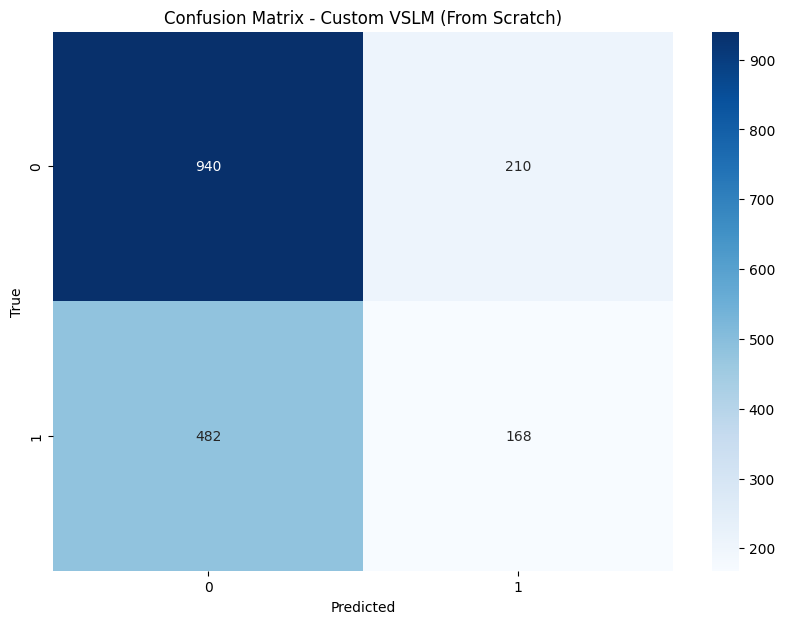

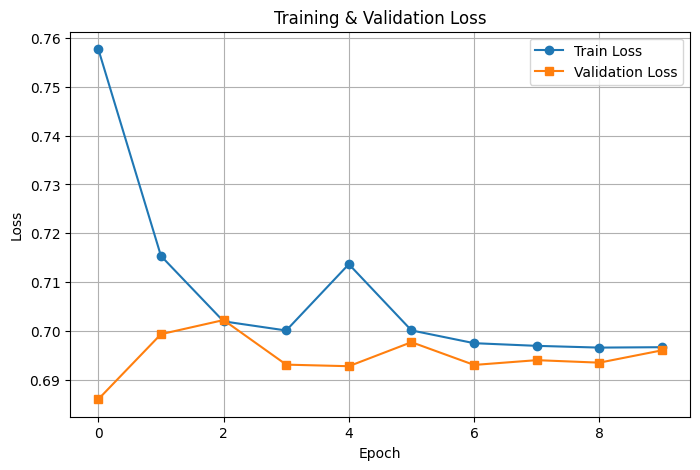

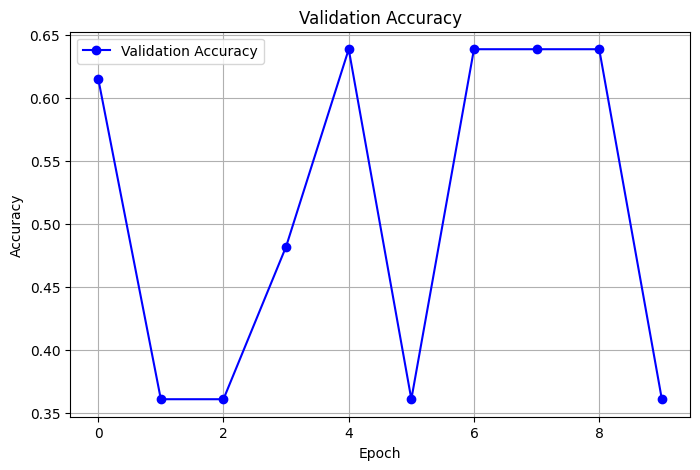

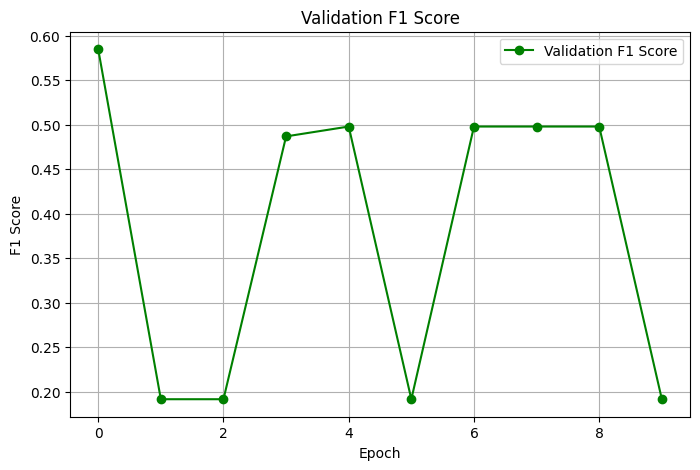


✓ Training complete! Plots saved to 'plots/' directory


In [2]:
# ====================== Imports ======================
import os
import json
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.utils.rnn import pad_sequence
import math

# ====================== CONFIG ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_DIR = "data/img"
JSONL_PATH = "data/dataset.jsonl"
NUM_LABELS = 2
LABEL_MAP = {0: 'non-hateful', 1: 'hateful'}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
BATCH_SIZE = 16  # Increased for better gradient estimates
EPOCHS = 25  # More epochs
VOCAB_SIZE = 30000
EMBED_DIM = 512
HIDDEN_DIM = 512
NUM_HEADS = 8
NUM_LAYERS = 4  # Reduced to prevent overfitting
MAX_SEQ_LEN = 128
IMG_SIZE = 224
PATCH_SIZE = 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
DROPOUT = 0.2  # Increased dropout

# ====================== Load JSONL with validation ======================
records = []
with open(JSONL_PATH, "r", encoding="utf-8") as f:
    for line in f:
        try:
            data = json.loads(line.strip())
            if all(k in data for k in ['label', 'text', 'img']):
                records.append(data)
            else:
                print(f"Skipping incomplete record: {data}")
        except json.JSONDecodeError:
            print(f"Skipping bad JSON: {line.strip()}")

# Calculate class weights for handling imbalance
label_counts = {}
for rec in records:
    label = rec['label']
    label_counts[label] = label_counts.get(label, 0) + 1

print(f"\nClass distribution:")
for label, count in sorted(label_counts.items()):
    print(f"  Class {label} ({LABEL_MAP[label]}): {count} samples ({count/len(records)*100:.1f}%)")

# Compute class weights (inverse frequency)
total_samples = len(records)
class_weights = torch.tensor([
    total_samples / (NUM_LABELS * label_counts.get(i, 1)) 
    for i in range(NUM_LABELS)
], dtype=torch.float32).to(device)
print(f"\nClass weights: {class_weights}")

# ====================== Build Vocabulary ======================
def build_vocab(records, vocab_size=30000):
    from collections import Counter
    word_counts = Counter()
    for rec in records:
        text = str(rec['text']).lower()
        words = text.split()
        word_counts.update(words)
    
    most_common = word_counts.most_common(vocab_size - 4)
    vocab = {
        '<PAD>': 0,
        '<UNK>': 1,
        '<SOS>': 2,
        '<EOS>': 3
    }
    for idx, (word, _) in enumerate(most_common, start=4):
        vocab[word] = idx
    return vocab

vocab = build_vocab(records, VOCAB_SIZE)
print(f"Vocabulary size: {len(vocab)}")

def text_to_indices(text, vocab, max_len=128):
    words = str(text).lower().split()
    indices = [vocab.get(word, vocab['<UNK>']) for word in words]
    indices = indices[:max_len]
    indices += [vocab['<PAD>']] * (max_len - len(indices))
    return indices

# ====================== Custom Processor ======================
class CustomVSLMProcessor:
    def __init__(self, vocab):
        self.vocab = vocab
        # Enhanced augmentation for better generalization
        self.image_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.val_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, images, text, is_training=True):
        if isinstance(images, Image.Image):
            images = [images]
        
        transform = self.image_transform if is_training else self.val_transform
        pixel_values = torch.stack([transform(img) for img in images])
        
        if isinstance(text, list):
            input_ids = [text_to_indices(t, self.vocab, MAX_SEQ_LEN) for t in text]
            input_ids = torch.tensor(input_ids)
        else:
            input_ids = torch.tensor([text_to_indices(text, self.vocab, MAX_SEQ_LEN)])
        
        attention_mask = (input_ids != self.vocab['<PAD>']).long()
        
        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }

# ====================== Dataset ======================
class MemeDataset(Dataset):
    def __init__(self, records, processor, img_dir, is_training=True):
        self.data = records
        self.processor = processor
        self.img_dir = img_dir
        self.is_training = is_training

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        image_path = os.path.join(self.img_dir, os.path.basename(row['img']))
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")

        image = Image.open(image_path).convert("RGB")
        text = str(row['text'])
        label = row['label']

        inputs = self.processor(images=image, text=[text], is_training=self.is_training)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = torch.tensor(label)
        return inputs

# ====================== Positional Encoding ======================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# ====================== Multi-Head Self-Attention ======================
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)
        return torch.matmul(attention, V)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        if mask is not None:
            # Ensure mask has correct shape [batch, 1, 1, seq_len] or [batch, 1, seq_len, seq_len]
            if mask.dim() == 2:  # [batch, seq_len]
                mask = mask.unsqueeze(1).unsqueeze(2)  # [batch, 1, 1, seq_len]
            elif mask.dim() == 3:  # [batch, seq_len, seq_len]
                mask = mask.unsqueeze(1)  # [batch, 1, seq_len, seq_len]
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        return self.W_o(attn_output)

# ====================== Feed-Forward Network ======================
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

# ====================== Transformer Encoder Layer ======================
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.2):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# ====================== Vision Encoder (Custom ViT-like) ======================
class VisionEncoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, d_model=512, num_layers=4, num_heads=8, dropout=0.2):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.d_model = d_model
        
        # Patch embedding
        self.patch_embed = nn.Conv2d(in_channels, d_model, kernel_size=patch_size, stride=patch_size)
        
        # CLS token and position embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, d_model))
        self.dropout = nn.Dropout(dropout)
        
        # Transformer layers
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_model * 4, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # [B, d_model, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, d_model]
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        # Add positional encoding
        x = x + self.pos_embed
        x = self.dropout(x)
        
        # Transformer layers
        for layer in self.layers:
            x = layer(x)
        
        x = self.norm(x)
        return x

# ====================== Text Encoder (Custom Transformer) ======================
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=512, num_layers=4, num_heads=8, max_len=128, dropout=0.2):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_model * 4, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, mask)
        
        x = self.norm(x)
        return x

# ====================== Cross-Attention Layer ======================
class CrossAttentionLayer(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.2):
        super().__init__()
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_model * 4, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key_value, mask=None):
        attn_output = self.cross_attn(query, key_value, key_value, mask)
        query = self.norm1(query + self.dropout(attn_output))
        ff_output = self.feed_forward(query)
        query = self.norm2(query + self.dropout(ff_output))
        return query

# ====================== Custom VSLM Model ======================
class CustomVSLM(nn.Module):
    def __init__(self, vocab_size, num_labels, d_model=512, num_heads=8, num_layers=4, dropout=0.2):
        super().__init__()
        
        # Vision encoder
        self.vision_encoder = VisionEncoder(
            img_size=IMG_SIZE, 
            patch_size=PATCH_SIZE, 
            d_model=d_model, 
            num_layers=num_layers, 
            num_heads=num_heads,
            dropout=dropout
        )
        
        # Text encoder
        self.text_encoder = TextEncoder(
            vocab_size=vocab_size, 
            d_model=d_model, 
            num_layers=num_layers, 
            num_heads=num_heads,
            dropout=dropout
        )
        
        # Cross-modal fusion with more layers
        self.vision_to_text = nn.ModuleList([
            CrossAttentionLayer(d_model, num_heads, dropout) for _ in range(3)
        ])
        self.text_to_vision = nn.ModuleList([
            CrossAttentionLayer(d_model, num_heads, dropout) for _ in range(3)
        ])
        
        # Enhanced classification head
        self.fusion = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.classifier = nn.Linear(d_model // 2, num_labels)
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)
        
    def forward(self, input_ids=None, attention_mask=None, pixel_values=None, labels=None):
        # Encode vision and text
        vision_embeds = self.vision_encoder(pixel_values)
        text_embeds = self.text_encoder(input_ids, attention_mask)
        
        # Cross-modal attention
        vision_attended = vision_embeds
        text_attended = text_embeds
        
        for v2t_layer, t2v_layer in zip(self.vision_to_text, self.text_to_vision):
            vision_attended = v2t_layer(vision_attended, text_attended, attention_mask)
            text_attended = t2v_layer(text_attended, vision_attended)
        
        # Pool and fuse
        vision_pooled = vision_attended[:, 0, :]  # CLS token
        text_pooled = text_attended[:, 0, :]      # CLS token
        
        fused = torch.cat([vision_pooled, text_pooled], dim=1)
        fused = self.fusion(fused)
        
        logits = self.classifier(fused)
        
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

# ====================== Train & Eval ======================
def train(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs["loss"]
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=labels)
            logits = outputs["logits"]
            loss = outputs["loss"]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return acc, avg_loss, all_preds, all_labels

def custom_collate(batch):
    collated = {}
    keys = batch[0].keys()
    for key in keys:
        if key == 'labels':
            collated[key] = torch.tensor([item[key] for item in batch])
        else:
            values = [item[key] for item in batch]
            if isinstance(values[0], torch.Tensor):
                collated[key] = torch.stack(values)
    return collated

# ====================== Run ======================
print(f"Using device: {device}")
print(f"Loaded {len(records)} records")

processor = CustomVSLMProcessor(vocab)
full_dataset = MemeDataset(records, processor, IMG_DIR, is_training=True)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create separate datasets with correct training flag
train_indices = train_dataset.indices
val_indices = val_dataset.indices
train_records = [records[i] for i in train_indices]
val_records = [records[i] for i in val_indices]

train_dataset = MemeDataset(train_records, processor, IMG_DIR, is_training=True)
val_dataset = MemeDataset(val_records, processor, IMG_DIR, is_training=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)

model = CustomVSLM(
    vocab_size=len(vocab),
    num_labels=NUM_LABELS,
    d_model=HIDDEN_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=3e-4, 
    epochs=EPOCHS, 
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos'
)

# ====================== Training Loop ======================
train_losses, val_losses = [], []
val_accuracies, val_f1s = [], []
final_preds, final_labels = [], []
best_val_loss = float('inf')

print("\nStarting training...")
best_f1 = 0
patience = 9
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train(model, train_loader, optimizer, scheduler)
    train_losses.append(train_loss)

    val_acc, val_loss, preds, labels = evaluate(model, val_loader)
    val_losses.append(val_loss)

    f1 = f1_score(labels, preds, average='weighted')
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")
    val_accuracies.append(val_acc)
    val_f1s.append(f1)

    # Save best model based on F1 score
    if f1 > best_f1:
        best_f1 = f1
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_custom_vslm_scratch.pt")
        print(f"✓ Saved best model! (F1: {f1:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

    final_preds = preds
    final_labels = labels

# Load best model for final evaluation
model.load_state_dict(torch.load("best_custom_vslm_scratch.pt"))
print("\n✓ Loaded best model for final evaluation")
val_acc, val_loss, final_preds, final_labels = evaluate(model, val_loader)

# ====================== Final Eval & Plots ======================
print("\n" + "="*50)
print("FINAL RESULTS - Custom VSLM from Scratch")
print("="*50)
print("\nClassification Report:")
print(classification_report(final_labels, final_preds, target_names=[str(k) for k in LABEL_MAP.keys()]))

os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(final_labels, final_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Custom VSLM (From Scratch)")
plt.savefig("plots/confusion_matrix_scratch.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.savefig("plots/loss_plot_scratch.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_accuracies, label="Validation Accuracy", marker="o", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.savefig("plots/accuracy_plot_scratch.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_f1s, label="Validation F1 Score", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score")
plt.legend()
plt.grid()
plt.savefig("plots/f1_score_scratch.png")
plt.show()

print("\n✓ Training complete! Plots saved to 'plots/' directory")

In [ ]:
# ====================== Imports ======================
import os
import json
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.utils.rnn import pad_sequence
import math
import random
import numpy as np

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ====================== CONFIG ======================
# ====================== CONFIG ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_DIR = "data/img"
JSONL_PATH = "data/dataset.jsonl"

NUM_LABELS = 2
LABEL_MAP = {0: 'non-hateful', 1: 'hateful'}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

BATCH_SIZE = 16  # Increased batch size for better GPU utilization
EPOCHS = 50  # Increased epochs to give model more training time
VOCAB_SIZE = 30000  # No change, keeps vocabulary size at 30K
HIDDEN_DIM = 768  # Increased hidden dimension for better capacity
NUM_HEADS = 12  # Increased number of attention heads for better attention mapping
NUM_LAYERS = 6  # Increased number of layers to better capture features
MAX_SEQ_LEN = 256  # Increased sequence length to capture more text context
IMG_SIZE = 224  # No change, keeps image size at 224x224
PATCH_SIZE = 32  # Increased patch size for Vision Transformer
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2  # Update number of patches for new patch size
DROPOUT = 0.3  # No change, regularization remains at 30%

# ====================== Load JSONL with validation ======================
records = []
with open(JSONL_PATH, "r", encoding="utf-8") as f:
    for line in f:
        try:
            data = json.loads(line.strip())
            if all(k in data for k in ['label', 'text', 'img']):
                records.append(data)
            else:
                print(f"Skipping incomplete record: {data}")
        except json.JSONDecodeError:
            print(f"Skipping bad JSON: {line.strip()}")

# Calculate class weights for handling imbalance
label_counts = {}
for rec in records:
    label = rec['label']
    label_counts[label] = label_counts.get(label, 0) + 1

print(f"\nClass distribution:")
for label, count in sorted(label_counts.items()):
    print(f"  Class {label} ({LABEL_MAP[label]}): {count} samples ({count/len(records)*100:.1f}%)")

# Compute class weights (inverse frequency with smoothing)
total_samples = len(records)
class_weights = torch.tensor([
    total_samples / (NUM_LABELS * label_counts.get(i, 1)) 
    for i in range(NUM_LABELS)
], dtype=torch.float32).to(device)
print(f"\nClass weights: {class_weights}")

# ====================== Build Vocabulary ======================
def build_vocab(records, vocab_size=30000):
    from collections import Counter
    word_counts = Counter()
    for rec in records:
        text = str(rec['text']).lower()
        words = text.split()
        word_counts.update(words)
    
    most_common = word_counts.most_common(vocab_size - 4)
    vocab = {
        '<PAD>': 0,
        '<UNK>': 1,
        '<SOS>': 2,
        '<EOS>': 3
    }
    for idx, (word, _) in enumerate(most_common, start=4):
        vocab[word] = idx
    return vocab

vocab = build_vocab(records, VOCAB_SIZE)
print(f"Vocabulary size: {len(vocab)}")

def text_to_indices(text, vocab, max_len=128):
    words = str(text).lower().split()
    indices = [vocab.get(word, vocab['<UNK>']) for word in words]
    indices = indices[:max_len]
    indices += [vocab['<PAD>']] * (max_len - len(indices))
    return indices

# ====================== Custom Processor ======================
from torchvision import transforms
from PIL import Image
import torch
import nltk

class CustomVSLMProcessor:
    def __init__(self, vocab, img_size=224, max_seq_len=128):
        self.vocab = vocab
        self.img_size = img_size
        self.max_seq_len = max_seq_len

        # Define common image transformations
        self.image_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Training image augmentations
        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            transforms.RandomGrayscale(p=0.1)
        ])

        # Validation transformations (no augmentation)
        self.val_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _tokenize_text(self, text):
        """
        Tokenizes input text into indices using the vocabulary
        """
        words = nltk.word_tokenize(text.lower())  # Tokenize using nltk
        input_ids = [self.vocab.get(word, self.vocab['<UNK>']) for word in words]
        input_ids = input_ids[:self.max_seq_len]  # Trim to max sequence length
        input_ids += [self.vocab['<PAD>']] * (self.max_seq_len - len(input_ids))  # Padding
        return torch.tensor(input_ids)

    def __call__(self, images, text, is_training=True):
        """
        Process image and text inputs for the model.
        """
        if isinstance(images, Image.Image):  # Ensure images are in list format
            images = [images]

        # Apply the transformations
        transform = self.image_transform
        if is_training:
            images = [self.train_transform(img) for img in images]
        else:
            images = [self.val_transform(img) for img in images]

        pixel_values = torch.stack(images)  # Stack images into a tensor

        # Tokenize the text
        if isinstance(text, list):
            input_ids = torch.stack([self._tokenize_text(t) for t in text])
        else:
            input_ids = self._tokenize_text(text).unsqueeze(0)

        # Create attention mask
        attention_mask = (input_ids != self.vocab['<PAD>']).long()

        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }


import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class MemeDataset(Dataset):
    def __init__(self, records, processor, img_dir, is_training=True):
        """
        Args:
            records (list): List of records containing image paths, text, and labels.
            processor (CustomVSLMProcessor): The processor that applies transformations.
            img_dir (str): Directory where images are stored.
            is_training (bool): Flag indicating if the dataset is for training or validation.
        """
        self.data = records
        self.processor = processor
        self.img_dir = img_dir
        self.is_training = is_training

    def __len__(self):
        """
        Return the number of records in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieve an item (image and text pair) from the dataset.

        Args:
            idx (int): Index of the item.

        Returns:
            dict: Contains processed image tensors, text tokens, and labels.
        """
        # Retrieve the record for this index
        row = self.data[idx]
        
        # Construct the image path
        image_path = os.path.join(self.img_dir, os.path.basename(row['img']))
        
        # Check if the image file exists
        if not os.path.exists(image_path):
            print(f"Warning: Image not found at {image_path}, skipping.")
            return None  # Return None if image is missing (can handle this during training loop)

        # Open and process the image
        image = Image.open(image_path).convert("RGB")

        # Text and label
        text = str(row['text'])
        label = row['label']

        # Process the image and text using the processor
        inputs = self.processor(images=image, text=[text], is_training=self.is_training)
        
        # Remove the batch dimension added by the processor
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        
        # Add the label to the inputs
        inputs["labels"] = torch.tensor(label)
        
        return inputs



# ====================== Positional Encoding ======================
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create a tensor to hold the positional encodings for each position
        pe = torch.zeros(max_len, d_model)
        
        # Position indices: positions from 0 to max_len - 1
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Dividing by 10000^(2i/d_model) for each dimension
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Applying sin and cos to even and odd dimensions respectively
        pe[:, 0::2] = torch.sin(position * div_term)  # Even dimensions use sin
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd dimensions use cos
        
        # Add a batch dimension to the positional encoding tensor
        pe = pe.unsqueeze(0)  # Shape becomes [1, max_len, d_model]
        
        # Register the positional encoding as a buffer, so it's not a parameter but part of the module
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Add positional encodings to the input tensor `x`.
        `x` is expected to have shape (batch_size, seq_len, d_model).
        """
        # `x.size(1)` gives the sequence length (seq_len)
        return x + self.pe[:, :x.size(1), :]


# ====================== Multi-Head Self-Attention ======================
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)
        return torch.matmul(attention, V)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1).unsqueeze(2)
            elif mask.dim() == 3:
                mask = mask.unsqueeze(1)
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        return self.W_o(attn_output)

# ====================== Feed-Forward Network ======================
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=3072, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

# ====================== Transformer Encoder Layer ======================
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=3072, dropout=0.3):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# ====================== Vision Encoder (Enhanced) ======================
class VisionEncoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, d_model=512, num_layers=4, num_heads=8, dropout=0.3):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.d_model = d_model
        
        # Enhanced patch embedding with CNN
        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_channels, d_model // 2, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(d_model // 2, d_model, kernel_size=patch_size, stride=patch_size)
        )
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, d_model))
        self.dropout = nn.Dropout(dropout)
        
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_model * 4, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        B = x.shape[0]
        
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        x = x + self.pos_embed
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x)
        
        x = self.norm(x)
        return x

# ====================== Text Encoder (Enhanced) ======================
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=512, num_layers=4, num_heads=8, max_len=128, dropout=0.3):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_model * 4, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, mask)
        
        x = self.norm(x)
        return x

# ====================== Cross-Attention Layer ======================
class CrossAttentionLayer(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.3):
        super().__init__()
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_model * 4, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key_value, mask=None):
        attn_output = self.cross_attn(query, key_value, key_value, mask)
        query = self.norm1(query + self.dropout(attn_output))
        ff_output = self.feed_forward(query)
        query = self.norm2(query + self.dropout(ff_output))
        return query

# ====================== Multimodal Fusion Layer ======================
class MultimodalFusion(nn.Module):
    def __init__(self, d_model, num_heads=6, dropout=0.3):
        super().__init__()
        self.v2t_attn = CrossAttentionLayer(d_model, num_heads, dropout)
        self.t2v_attn = CrossAttentionLayer(d_model, num_heads, dropout)
        
        # Gated fusion
        self.gate_v = nn.Linear(d_model * 2, d_model)
        self.gate_t = nn.Linear(d_model * 2, d_model)
        
    def forward(self, vision, text, text_mask=None):
        # Cross-attention
        v_attended = self.v2t_attn(vision, text, text_mask)
        t_attended = self.t2v_attn(text, vision)
        
        # Extract CLS tokens
        v_cls = v_attended[:, 0, :]
        t_cls = t_attended[:, 0, :]
        
        # Gated fusion
        combined = torch.cat([v_cls, t_cls], dim=-1)
        gate_v = torch.sigmoid(self.gate_v(combined))
        gate_t = torch.sigmoid(self.gate_t(combined))
        
        fused = gate_v * v_cls + gate_t * t_cls
        return fused

# ====================== Custom VSLM Model ======================
class CustomVSLM(nn.Module):
    def __init__(self, vocab_size, num_labels, d_model=512, num_heads=8, num_layers=4, dropout=0.3):
        super().__init__()
        
        self.vision_encoder = VisionEncoder(
            img_size=IMG_SIZE, 
            patch_size=PATCH_SIZE, 
            d_model=d_model, 
            num_layers=num_layers, 
            num_heads=num_heads,
            dropout=dropout
        )
        
        self.text_encoder = TextEncoder(
            vocab_size=vocab_size, 
            d_model=d_model, 
            num_layers=num_layers, 
            num_heads=num_heads,
            dropout=dropout
        )
        
        # Multiple fusion layers
        self.fusion_layers = nn.ModuleList([
            MultimodalFusion(d_model, num_heads, dropout) for _ in range(4)
        ])
        
        # Enhanced classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, d_model // 4),
            nn.LayerNorm(d_model // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 4, num_labels)
        )
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)
        
    def forward(self, input_ids=None, attention_mask=None, pixel_values=None, labels=None):
        vision_embeds = self.vision_encoder(pixel_values)
        text_embeds = self.text_encoder(input_ids, attention_mask)
        
        # Multi-layer fusion
        fused = None
        for fusion_layer in self.fusion_layers:
            layer_fused = fusion_layer(vision_embeds, text_embeds, attention_mask)
            if fused is None:
                fused = layer_fused
            else:
                fused = fused + layer_fused
        
        fused = fused / len(self.fusion_layers)  # Average
        
        logits = self.classifier(fused)
        
        if labels is not None:
            # Focal loss for better handling of hard examples
            ce_loss = F.cross_entropy(logits, labels, weight=class_weights, reduction='none')
            pt = torch.exp(-ce_loss)
            focal_loss = ((1 - pt) ** 2 * ce_loss).mean()
            return {"loss": focal_loss, "logits": logits}
        else:
            return {"logits": logits}

# ====================== Mixup Augmentation ======================
def mixup_data(x_img, x_ids, x_mask, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x_img.size()[0]
    index = torch.randperm(batch_size).to(x_img.device)

    mixed_img = lam * x_img + (1 - lam) * x_img[index, :]
    mixed_ids = x_ids  # Don't mix text IDs
    mixed_mask = x_mask
    y_a, y_b = y, y[index]
    return mixed_img, mixed_ids, mixed_mask, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ====================== Train & Eval ======================
def train(model, dataloader, optimizer, scheduler, use_mixup=True):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        
        if use_mixup and random.random() > 0.5:
            mixed_img, mixed_ids, mixed_mask, y_a, y_b, lam = mixup_data(
                inputs['pixel_values'], inputs['input_ids'], inputs['attention_mask'], labels
            )
            outputs = model(input_ids=mixed_ids, attention_mask=mixed_mask, pixel_values=mixed_img)
            loss_fn = lambda pred, y: F.cross_entropy(pred, y, weight=class_weights)
            loss = mixup_criterion(loss_fn, outputs['logits'], y_a, y_b, lam)
        else:
            outputs = model(**inputs, labels=labels)
            loss = outputs["loss"]
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=labels)
            logits = outputs["logits"]
            loss = outputs["loss"]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return acc, avg_loss, all_preds, all_labels

def custom_collate(batch):
    collated = {}
    keys = batch[0].keys()
    for key in keys:
        if key == 'labels':
            collated[key] = torch.tensor([item[key] for item in batch])
        else:
            values = [item[key] for item in batch]
            if isinstance(values[0], torch.Tensor):
                collated[key] = torch.stack(values)
    return collated

# ====================== Run ======================
print(f"Using device: {device}")
print(f"Loaded {len(records)} records")

processor = CustomVSLMProcessor(vocab)
full_dataset = MemeDataset(records, processor, IMG_DIR, is_training=True)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_indices = train_dataset.indices
val_indices = val_dataset.indices
train_records = [records[i] for i in train_indices]
val_records = [records[i] for i in val_indices]

train_dataset = MemeDataset(train_records, processor, IMG_DIR, is_training=True)
val_dataset = MemeDataset(val_records, processor, IMG_DIR, is_training=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)

model = CustomVSLM(
    vocab_size=len(vocab),
    num_labels=NUM_LABELS,
    d_model=HIDDEN_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Warmup + Cosine schedule
warmup_epochs = 3
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=5e-4, 
    epochs=EPOCHS, 
    steps_per_epoch=len(train_loader),
    pct_start=warmup_epochs/EPOCHS,
    anneal_strategy='cos'
)

# ====================== Training Loop ======================
train_losses, val_losses = [], []
val_accuracies, val_f1s = [], []
final_preds, final_labels = [], []

print("\nStarting training...")
best_f1 = 0
best_acc = 0
patience = 10
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train(model, train_loader, optimizer, scheduler, use_mixup=(epoch > 5))
    train_losses.append(train_loss)

    val_acc, val_loss, preds, labels = evaluate(model, val_loader)
    val_losses.append(val_loss)

    f1 = f1_score(labels, preds, average='weighted')
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")
    val_accuracies.append(val_acc)
    val_f1s.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_acc = val_acc
        torch.save(model.state_dict(), "best_custom_vslm_scratch.pt")
        print(f"✓ Saved best model! (Acc: {val_acc:.4f}, F1: {f1:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

    final_preds = preds
    final_labels = labels

model.load_state_dict(torch.load("best_custom_vslm_scratch.pt"))
print(f"\n✓ Loaded best model (Acc: {best_acc:.4f}, F1: {best_f1:.4f})")
val_acc, val_loss, final_preds, final_labels = evaluate(model, val_loader)

# ====================== Final Eval & Plots ======================
print("\n" + "="*50)
print("FINAL RESULTS - Custom VSLM from Scratch")
print("="*50)
print("\nClassification Report:")
print(classification_report(final_labels, final_preds, target_names=[str(k) for k in LABEL_MAP.keys()]))

os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(final_labels, final_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Custom VSLM (From Scratch)")
plt.savefig("plots/confusion_matrix_scratch.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.savefig("plots/loss_plot_scratch.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_accuracies, label="Validation Accuracy", marker="o", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.savefig("plots/accuracy_plot_scratch.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_f1s, label="Validation F1 Score", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score")
plt.legend()
plt.grid()
plt.savefig("plots/f1_score_scratch.png")
plt.show()

print("\n✓ Training complete! Plots saved to 'plots/' directory")

Skipping incomplete record: {'id': 16395, 'img': 'img/16395.png', 'text': 'handjobs sold seperately'}
Skipping incomplete record: {'id': 37405, 'img': 'img/37405.png', 'text': 'introducing fidget spinner for women'}
Skipping incomplete record: {'id': 94180, 'img': 'img/94180.png', 'text': "happy pride month let's go beat up lesbians"}
Skipping incomplete record: {'id': 54321, 'img': 'img/54321.png', 'text': 'laughs in [majority of u.s crime rate]'}
Skipping incomplete record: {'id': 97015, 'img': 'img/97015.png', 'text': 'finds out those 72 virgins.. are goats'}
Skipping incomplete record: {'id': 73506, 'img': 'img/73506.png', 'text': 'look your dad fucked goats.. i capped him...sorry..'}
Skipping incomplete record: {'id': 5429, 'img': 'img/05429.png', 'text': 'claims that her ancestors created a safe space for jews these are her ancestors'}
Skipping incomplete record: {'id': 70691, 'img': 'img/70691.png', 'text': 'overdose'}
Skipping incomplete record: {'id': 69421, 'img': 'img/69421.

Evaluating: 100%|██████████| 150/150 [00:16<00:00,  9.01it/s]


Train Loss: 0.2550 | Val Loss: 0.1947 | Val Acc: 0.3772 | Val F1: 0.2066
✓ Saved best model! (Acc: 0.3772, F1: 0.2066)

Epoch 2/40


Evaluating: 100%|██████████| 150/150 [00:18<00:00,  8.01it/s]


Train Loss: 0.1943 | Val Loss: 0.1807 | Val Acc: 0.3772 | Val F1: 0.2066

Epoch 3/40


Evaluating: 100%|██████████| 150/150 [00:17<00:00,  8.39it/s]


Train Loss: 0.1859 | Val Loss: 0.1813 | Val Acc: 0.3772 | Val F1: 0.2066

Epoch 4/40


Evaluating: 100%|██████████| 150/150 [00:18<00:00,  8.15it/s]


Train Loss: 0.1839 | Val Loss: 0.1816 | Val Acc: 0.3772 | Val F1: 0.2066

Epoch 5/40


Evaluating: 100%|██████████| 150/150 [00:17<00:00,  8.58it/s]


Train Loss: 0.1835 | Val Loss: 0.1809 | Val Acc: 0.3772 | Val F1: 0.2066

Epoch 6/40


Training:  16%|█▌        | 94/600 [00:20<01:50,  4.59it/s]